# House Sales in King County, USA(Day3)

URL:https://www.kaggle.com/harlfoxem/housesalesprediction/data

### 変数の説明

<pre>
・id            ：家の識別番号
・date          ：家の売却日
・price         ：価格(目的変数)
・bedrooms      ：寝室の数
・bathrooms     ：浴室の数
・sqft_living   ：延床面積(単位：フィート)
・sqft_lot      ：敷地面積(単位：フィート)
・floors        ：フロア数
・waterfront    ：水辺
・view          ：見られた回数
・condition     ：状態の良さ
・grade         ：キング郡の制度に基づく等級
・sqft_above    ：地上面積
・sqft_basement ：地下面積
・yr_built      ：築年
・yr_renovated  ：リフォームされた年
・zipcode       ：郵便番号
・lat           ：緯度
・long          ：経度
・sqft_living15 ：延床面積(2015年)
・sqft_lot15    ：敷地面積(2015年)
</pre>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR

### データ読込

In [2]:
df_data = pd.read_csv("./kc_house_data.csv")
print(df_data.columns)
display(df_data.head())
display(df_data.tail())

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


### 欠損値チェック

In [3]:
df_data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

⇒欠損値なし

priceを$10^5$で割っておく

In [4]:
df_data['price'] = df_data['price'] / 10**5

### グラフ化

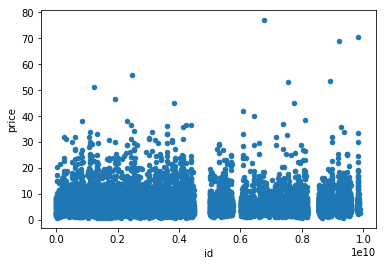

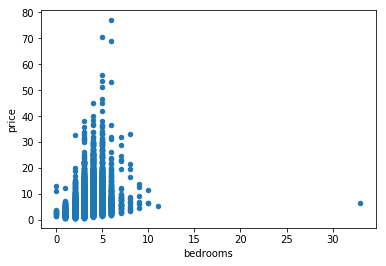

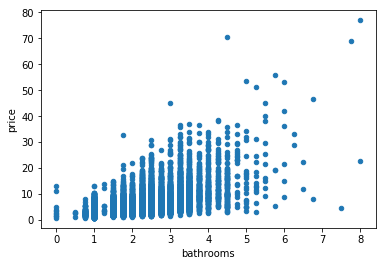

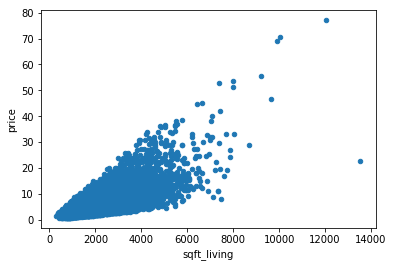

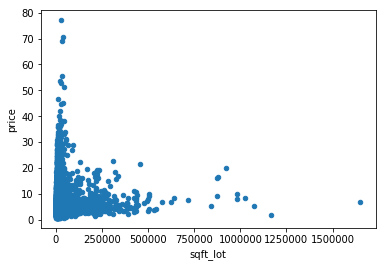

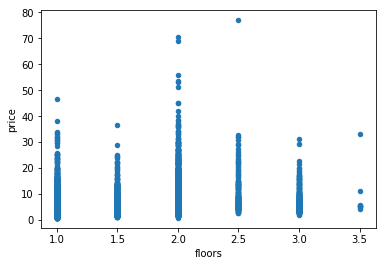

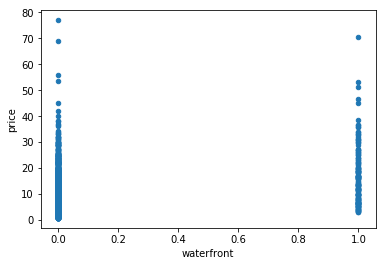

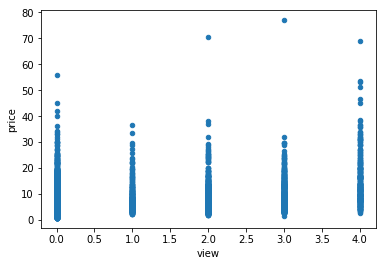

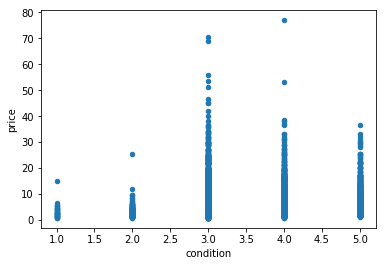

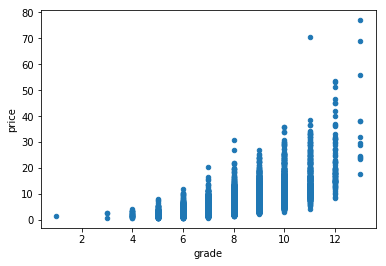

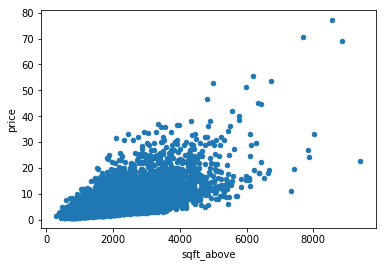

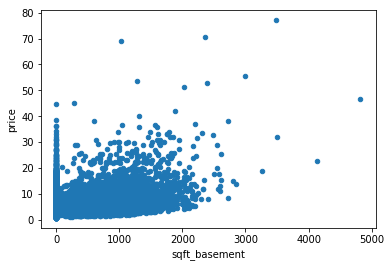

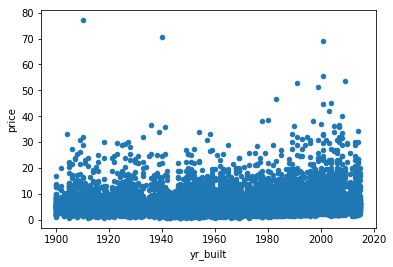

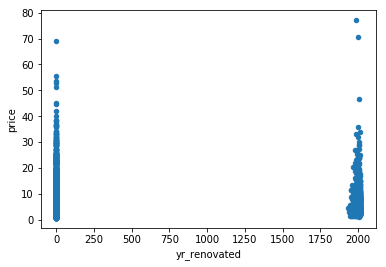

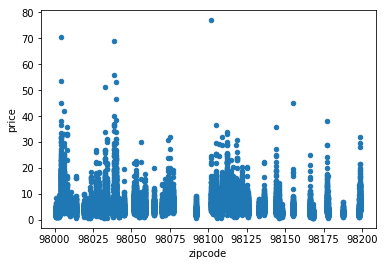

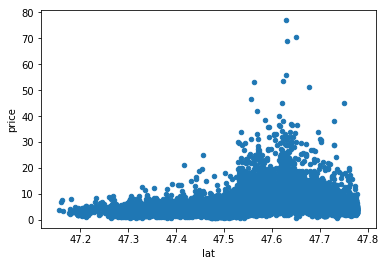

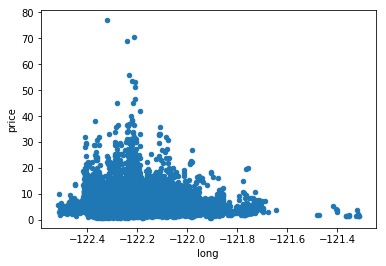

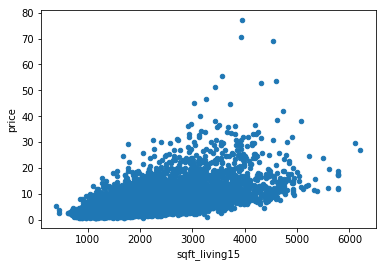

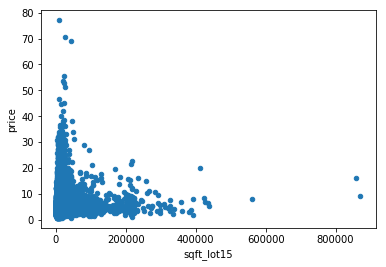

In [5]:
for c in df_data.columns:
    if (c != 'price') & (c != 'date'):
        df_data[[c,'price']].plot(kind='scatter',x=c,y='price')

以下の変数は価格との相関がありそう<br>
sqft_living<br>
grade<br>
sqft_above<br>
sqft_living15

### 変数の処理

In [6]:
#idは明らかに無関係なので落としておく
df_data = df_data.drop('id',axis=1)

In [7]:
#dateを曜日と月の情報に変換
df_data['dow'] = pd.to_datetime(df_data.date).map(lambda x:'dow'+str(x.weekday()))
df_data['month'] = pd.to_datetime(df_data.date).map(lambda x:'month'+str(x.month))

In [8]:
#yr_renovatedをrenovateしたか否かに変換
df_data['yr_renovated_bin'] = np.array(df_data['yr_renovated'] != 0)*1
df_data['yr_renovated_bin'].value_counts().sort_index()

0    20699
1      914
Name: yr_renovated_bin, dtype: int64

In [9]:
#zipcodeと曜日、月をカテゴリ変数化
df_data['zipcode_str'] = df_data['zipcode'].astype(str).map(lambda x:'zip_'+x)
df_data = pd.concat([df_data,pd.get_dummies(df_data['zipcode_str'])],axis=1)
df_data = pd.concat([df_data,pd.get_dummies(df_data.dow)],axis=1)
df_data = pd.concat([df_data,pd.get_dummies(df_data.month)],axis=1)

In [10]:
#元の変数を削除
df_data = df_data.drop(['date','zipcode','zipcode_str','yr_renovated','month','dow'],axis=1)

In [11]:
df_data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,month11,month12,month2,month3,month4,month5,month6,month7,month8,month9
0,2.21900,3,1.00,1180,5650,1.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
1,5.38000,3,2.25,2570,7242,2.0,0,0,3,7,...,0,1,0,0,0,0,0,0,0,0
2,1.80000,2,1.00,770,10000,1.0,0,0,3,6,...,0,0,1,0,0,0,0,0,0,0
3,6.04000,4,3.00,1960,5000,1.0,0,0,5,7,...,0,1,0,0,0,0,0,0,0,0
4,5.10000,3,2.00,1680,8080,1.0,0,0,3,8,...,0,0,1,0,0,0,0,0,0,0
5,12.25000,4,4.50,5420,101930,1.0,0,0,3,11,...,0,0,0,0,0,1,0,0,0,0
6,2.57500,3,2.25,1715,6819,2.0,0,0,3,7,...,0,0,0,0,0,0,1,0,0,0
7,2.91850,3,1.50,1060,9711,1.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
8,2.29500,3,1.00,1780,7470,1.0,0,0,3,7,...,0,0,0,0,1,0,0,0,0,0
9,3.23000,3,2.50,1890,6560,2.0,0,0,3,7,...,0,0,0,1,0,0,0,0,0,0


In [12]:
max_row = len(df_data)
#80%のデータを学習に使用
separate = int(max_row * 4 / 5)
y = df_data['price']
X = df_data.drop('price',axis=1)
X_train = X.iloc[0:separate,:]

display(X_train)

regr = LinearRegression(fit_intercept=True)

#学習
#全変数を用いて学習を行う
regr.fit(X, y)
print(regr.coef_,regr.intercept_)

#検証
X_pred = X.iloc[separate + 1:max_row,:]
y = df_data['price'].iloc[separate + 1:max_row].values
y_pred = regr.predict(X_pred)
mse_all = mean_squared_error(y, y_pred)
mae_all = mean_absolute_error(y, y_pred)

print("MSE=%s"%round(mse_all,3) )
print("RMSE=%s"%round(np.sqrt(mse_all), 3) )
print("MAE=%s"%round(mae_all,3) )

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,month11,month12,month2,month3,month4,month5,month6,month7,month8,month9
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,0,0,0,0,0,0,0,0,0,0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,0,1,0,0,0,0,0,0,0,0
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,0,0,1,0,0,0,0,0,0,0
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,0,1,0,0,0,0,0,0,0,0
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,0,0,1,0,0,0,0,0,0,0
5,4,4.50,5420,101930,1.0,0,0,3,11,3890,...,0,0,0,0,0,1,0,0,0,0
6,3,2.25,1715,6819,2.0,0,0,3,7,1715,...,0,0,0,0,0,0,1,0,0,0
7,3,1.50,1060,9711,1.0,0,0,3,7,1060,...,0,0,0,0,0,0,0,0,0,0
8,3,1.00,1780,7470,1.0,0,0,3,7,1050,...,0,0,0,0,1,0,0,0,0,0
9,3,2.50,1890,6560,2.0,0,0,3,7,1890,...,0,0,0,1,0,0,0,0,0,0


[-2.70873399e-01  2.34932758e-01 -5.02457569e+07  2.43386514e-06
 -4.52139766e-01  6.57297801e+00  5.51981892e-01  2.63112446e-01
  5.69061009e-01  5.02457569e+07  5.02457569e+07 -7.01346053e-03
  2.12768085e+00 -1.31638998e+00  1.04300678e-04 -1.27591193e-06
  3.52864241e-01 -3.10025363e+01 -3.06618517e+01 -3.12244744e+01
 -2.38202466e+01 -2.84987384e+01 -2.87138416e+01 -2.90465772e+01
 -2.89481760e+01 -3.00418104e+01 -3.06265405e+01 -3.02086112e+01
 -3.05970283e+01 -3.05609295e+01 -3.14626174e+01 -2.94925176e+01
 -2.94837260e+01 -3.07290953e+01 -2.90728788e+01 -3.09869704e+01
 -3.09534973e+01 -3.10691841e+01 -2.80591299e+01 -2.97729557e+01
 -3.05063750e+01 -1.84792675e+01 -2.64079387e+01 -3.08872707e+01
 -2.97449480e+01 -2.93273266e+01 -2.95641975e+01 -3.07683960e+01
 -3.03620531e+01 -3.08627386e+01 -3.03952044e+01 -3.01289324e+01
 -3.16545664e+01 -3.02743132e+01 -2.96724397e+01 -2.96571529e+01
 -3.05104782e+01 -3.12425152e+01 -2.65758462e+01 -2.84325820e+01
 -2.70656614e+01 -3.00854

説明変数を減らしてみる

### 相関係数の計算

In [13]:
#相関行列
df_data.corr().style.background_gradient().format('{:.2f}')

priceとの相関の大きさが0.2以上のもののみ採用してみる

In [14]:
max_row = len(df_data)
#80%のデータを学習に使用
separate = int(max_row * 4 / 5)
y = df_data['price']
X = df_data.loc[:,['bathrooms','sqft_living','floors','waterfront','view','grade','sqft_above','sqft_basement','lat','sqft_living15','zip_98004','zip_98039','zip_98040']]
X_train = X.iloc[0:separate,:]

display(X_train)

regr = LinearRegression(fit_intercept=True)

#学習
regr.fit(X, y)
print(regr.coef_,regr.intercept_)

#検証
X_pred = X.iloc[separate + 1:max_row,:]
y = df_data['price'].iloc[separate + 1:max_row].values
y_pred = regr.predict(X_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
print("MSE=%s"%round(mse,3) )
print("RMSE=%s"%round(np.sqrt(mse), 3) )
print("MAE=%s"%round(mae,3) )
print("\n(全変数を用いた場合)")
print("MSE_ALL=%s"%round(mse_all,3) )
print("RMSE_ALL=%s"%round(np.sqrt(mse_all), 3) )
print("MAE_ALL=%s"%round(mae_all,3) )

,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,lat,sqft_living15,zip_98004,zip_98039,zip_98040
0,1.00,1180,1.0,0,0,7,1180,0,47.5112,1340,0,0,0
1,2.25,2570,2.0,0,0,7,2170,400,47.7210,1690,0,0,0
2,1.00,770,1.0,0,0,6,770,0,47.7379,2720,0,0,0
3,3.00,1960,1.0,0,0,7,1050,910,47.5208,1360,0,0,0
4,2.00,1680,1.0,0,0,8,1680,0,47.6168,1800,0,0,0
5,4.50,5420,1.0,0,0,11,3890,1530,47.6561,4760,0,0,0
6,2.25,1715,2.0,0,0,7,1715,0,47.3097,2238,0,0,0
7,1.50,1060,1.0,0,0,7,1060,0,47.4095,1650,0,0,0
8,1.00,1780,1.0,0,0,7,1050,730,47.5123,1780,0,0,0
9,2.50,1890,2.0,0,0,7,1890,0,47.3684,2390,0,0,0


[-1.18439960e-01  1.13840336e-03 -7.86526340e-02  6.05325702e+00
  7.22462751e-01  7.93329355e-01  5.72316058e-04  5.66087303e-04
  6.52026920e+00 -1.09816410e-04  5.80896998e+00  1.15163032e+01
  3.47411369e+00] -314.1201359208755
MSE=3.531
RMSE=1.879
MAE=1.206

(全変数を用いた場合)
MSE_ALL=2.515
RMSE_ALL=1.586
MAE_ALL=0.955


誤差が増えた

### Cross Validation(Lasso)

In [15]:
X, y = df_data.drop('price',axis=1), df_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

param_grid = {'alpha':[1e-5, 1e-4,1e-3, 1e-2, 1e-1]}
cv = GridSearchCV(Lasso(),param_grid=param_grid,cv=5)
cv.fit(X_train,y_train)

C:\Users\yn5349.ITEC\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\yn5349.ITEC\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\yn5349.ITEC\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\yn5349.ITEC\AppData\Local\Continuum\anaconda3\lib\site-packages\

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
cv.best_params_

{'alpha': 1e-05}

In [17]:
y_pred = cv.best_estimator_.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred)
mae_lasso = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse_lasso,3) )
print("RMSE=%s"%round(np.sqrt(mse_lasso), 3) )
print("MAE=%s"%round(mae_lasso,3) )
print("\n(CVなし)")
print("MSE_ALL=%s"%round(mse_all,3) )
print("RMSE_ALL=%s"%round(np.sqrt(mse_all), 3) )
print("MAE_ALL=%s"%round(mae_all,3) )

MSE=2.452
RMSE=1.566
MAE=0.955

(CVなし)
MSE_ALL=2.515
RMSE_ALL=1.586
MAE_ALL=0.955


CVを使用しない場合とあまり変わらないように見える

----------------------------------------------------------↓Day3以降に取り組んだ内容----------------------------------------------------------------------

### ランダムフォレスト

In [18]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=10)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))


score= 0.9773541312520418


In [19]:
y_pred = clf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse_rf,3) )
print("RMSE=%s"%round(np.sqrt(mse_rf), 3) )
print("MAE=%s"%round(mae_rf,3) )

MSE=1.949
RMSE=1.396
MAE=0.741


#### 説明変数を減らす

In [20]:
imp = {}
sum = 0
fti = clf.feature_importances_
for i,feat in enumerate(X_train.columns):
    imp[feat] = fti[i]

#変数を重要度の高い順にソート
imp = sorted(imp.items(), key=lambda x: -x[1])
display(imp)

[('sqft_living', 0.3503115607485001),
 ('grade', 0.23091003171017177),
 ('lat', 0.15436554081110687),
 ('long', 0.07435236585900651),
 ('sqft_living15', 0.031699527482953745),
 ('waterfront', 0.02610534092472335),
 ('yr_built', 0.02070434277328049),
 ('sqft_above', 0.01971164735308831),
 ('bathrooms', 0.01439919715001885),
 ('view', 0.013031744200095457),
 ('sqft_lot15', 0.012737773687266127),
 ('sqft_lot', 0.010190765510325304),
 ('zip_98004', 0.00533929493497229),
 ('sqft_basement', 0.004321022112367233),
 ('condition', 0.002676388298672048),
 ('dow0', 0.0026098966414779727),
 ('floors', 0.002141112059150975),
 ('bedrooms', 0.001972182273908789),
 ('zip_98040', 0.0015010055024559554),
 ('zip_98039', 0.0014758166680435172),
 ('dow1', 0.0012130255155563398),
 ('yr_renovated_bin', 0.0009485379915565118),
 ('zip_98112', 0.0009454237731634788),
 ('dow2', 0.0008895144516211153),
 ('dow3', 0.0008812439678253043),
 ('month4', 0.0008796071120981856),
 ('month6', 0.0008403805890394255),
 ('mon

重要度の高い5変数を使用してランダムフォレスト

In [21]:
X, y = df_data.loc[:,['grade', 'sqft_living', 'lat', 'long', 'sqft_living15']], df_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

y_pred = clf.predict(X_test)
mse_rf1 = mean_squared_error(y_test, y_pred)
mae_rf1 = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse_rf1,3) )
print("RMSE=%s"%round(np.sqrt(mse_rf1), 3) )
print("MAE=%s"%round(mae_rf1,3) )

score= 0.966463055707078
MSE=2.369
RMSE=1.539
MAE=0.817


延床面積が年数の経過によって増えるとは考えにくいので、sqft_livingとsqft_living15は相関がありそう。<br>
sqft_living15の代わりにwaterfrontを説明変数として使用する。

In [22]:
X, y = df_data.loc[:,['grade', 'sqft_living', 'lat', 'long', 'waterfront']], df_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

y_pred = clf.predict(X_test)
mse_rf2 = mean_squared_error(y_test, y_pred)
mae_rf2 = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse_rf2,3) )
print("RMSE=%s"%round(np.sqrt(mse_rf2), 3) )
print("MAE=%s"%round(mae_rf2,3) )

score= 0.975096891065865
MSE=1.916
RMSE=1.384
MAE=0.776


誤差が減った

Cross Validationでパラメータチューニング

In [23]:
%%time
X, y = df_data.loc[:,['grade', 'sqft_living', 'lat', 'long', 'waterfront']], df_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

#param_grid = {'n_estimators':[5, 10, 20, 30, 50, 100, 300,500,1000,2000],'max_depth':[3, 5, 10, 15, 20, 25, 30, 40, 50, 100],'max_features':[1,2,3,4,5],'min_samples_split':[3, 5, 10, 15, 20, 25, 30, 40, 50, 100]}
#計算時間短縮のため、上記パラメータでのbestのみ下記に記述
param_grid = {'n_estimators':[1000],'max_depth':[25],'max_features':[1],'min_samples_split':[3]}
cv = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=5)
cv.fit(X_train,y_train)

display(cv.best_params_)
print("score=", cv.score(X_train, y_train))

{'max_depth': 25,
 'max_features': 1,
 'min_samples_split': 3,
 'n_estimators': 1000}

score= 0.9746163542757103
Wall time: 1min 41s


In [24]:
y_pred = cv.best_estimator_.predict(X_test)
mse_rf3 = mean_squared_error(y_test, y_pred)
mae_rf3 = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse_rf3,3) )
print("RMSE=%s"%round(np.sqrt(mse_rf3), 3) )
print("MAE=%s"%round(mae_rf3,3) )

MSE=1.649
RMSE=1.284
MAE=0.718


### SVM

RBFカーネルを使用

In [25]:
%%time
X, y = df_data.loc[:,['grade', 'sqft_living', 'lat', 'long', 'waterfront']], df_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

#parameters = {'kernel':['rbf'], 'C':[1,5,10,20], 'gamma':[2**-15,1,5,10,20]}
parameters = {'kernel':['rbf'], 'C':[20], 'gamma':[2**-15]}
model = SVR()
clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'C': 20, 'gamma': 3.0517578125e-05, 'kernel': 'rbf'} 0.5022202137117585
Wall time: 1min 14s


In [26]:
y_pred = clf.best_estimator_.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred)
mae_svm = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse_svm,3) )
print("RMSE=%s"%round(np.sqrt(mse_svm), 3) )
print("MAE=%s"%round(mae_svm,3) )

MSE=6.546
RMSE=2.559
MAE=1.56


あまり精度は良くならなかった

### ニューラルネットワーク

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn import KerasRegressor

#モデル構築
model = Sequential()
model.add(Dense(120, activation='relu',input_dim=X_train.shape[1]))
model.add(Dense(100, activation='relu',input_dim=120))
model.add(Dense(1, activation='softmax'))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)

model.compile(loss='mean_squared_error',
              optimizer=sgd)

C:\Users\yn5349.ITEC\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
# 計算の実行
#fit = model.fit(X_train, y_train,
#          epochs=50,
#          batch_size=20,validation_data=(X_test, y_test))
#
# 各epochにおける損失と精度をdfに入れる
#df = pd.DataFrame(fit.history)

# グラフ化
#df[["loss", "val_loss"]].plot()
#plt.ylabel("loss")
#plt.xlabel("epoch")
#plt.show()

#df[["acc", "val_acc"]].plot()
#plt.ylabel("acc")
#plt.xlabel("epoch")
#plt.ylim([0,1.0])
#plt.show()

In [29]:
#y_pred = model.predict(X_test)
#mse = mean_squared_error(y_test, y_pred)
#mae = mean_absolute_error(y_test, y_pred)
#print("MSE=%s"%round(mse,3) )
#print("RMSE=%s"%round(np.sqrt(mse), 3) )
#print("MAE=%s"%round(mae,3) )

時間切れによりニューラルネットワーク未実装

### まとめ

In [30]:
pd.DataFrame([['全変数で線形回帰(Day2)',mse_all,np.sqrt(mse_all),mae_all],
              ['相関係数で説明変数を決定し、線形回帰(Day2)',mse,np.sqrt(mse),mae],
              ['Lasso(Day2)',mse_lasso,np.sqrt(mse_lasso),mae_lasso],
              ['ランダムフォレスト(Day3)',mse_rf3,np.sqrt(mse_rf3),mae_rf3],
              ['SVM(Day3)',mse_svm,np.sqrt(mse_svm),mae_svm]
             ],
            columns=('','MSE','RMSE','MAE'))

,,MSE,RMSE,MAE
0,全変数で線形回帰(Day2),2.514845,1.585826,0.955379
1,相関係数で説明変数を決定し、線形回帰(Day2),3.531006,1.879097,1.206303
2,Lasso(Day2),2.452472,1.566037,0.954861
3,ランダムフォレスト(Day3),1.649288,1.284246,0.717668
4,SVM(Day3),6.546301,2.558574,1.560041


精度としては、ランダムフォレストが最もよくなった。<br>
ただし、今回時間切れで試せなかったが、SVMでRBFカーネル以外を用いる、ニューラルネットワークを使用するなどでさらに良い精度が出るかもしれない。